<a href="https://colab.research.google.com/github/manasamorthad/Machine-Learning/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("=== LOADING BREAST CANCER WISCONSIN DATASET ===")
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of samples: {X.shape[0]}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")
print(f"Target distribution: {np.bincount(y)}")
print(f"  - {target_names[0]}: {np.sum(y == 0)} samples")
print(f"  - {target_names[1]}: {np.sum(y == 1)} samples")

=== LOADING BREAST CANCER WISCONSIN DATASET ===
Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target names: ['malignant' 'benign']
Target distribution: [212 357]
  - malignant: 212 samples
  - benign: 357 samples


In [ ]:
# Create DataFrame for better visualization
print("\n=== DATA CLEANING AND PREPROCESSING ===")
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

# Check for missing values
print("\n1. Checking for missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\n2. Number of duplicate rows: {df.duplicated().sum()}")

# Check data types
print("\n3. Data types:")
print(df.dtypes)

# Check for infinite values
print(f"\n4. Infinite values in features: {np.any(np.isinf(X))}")

# Basic statistics
print("\n5. Basic statistics:")
print(df.describe())

# Remove duplicates if any
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Removed {df.duplicated().sum()} duplicates")

# Update X and y after cleaning
X_clean = df.drop(['target', 'diagnosis'], axis=1).values
y_clean = df['target'].values

print(f"\nShape after cleaning: {X_clean.shape}")


=== DATA CLEANING AND PREPROCESSING ===

1. Checking for missing values:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
diagnosis                  


=== EXPLORATORY DATA ANALYSIS ===


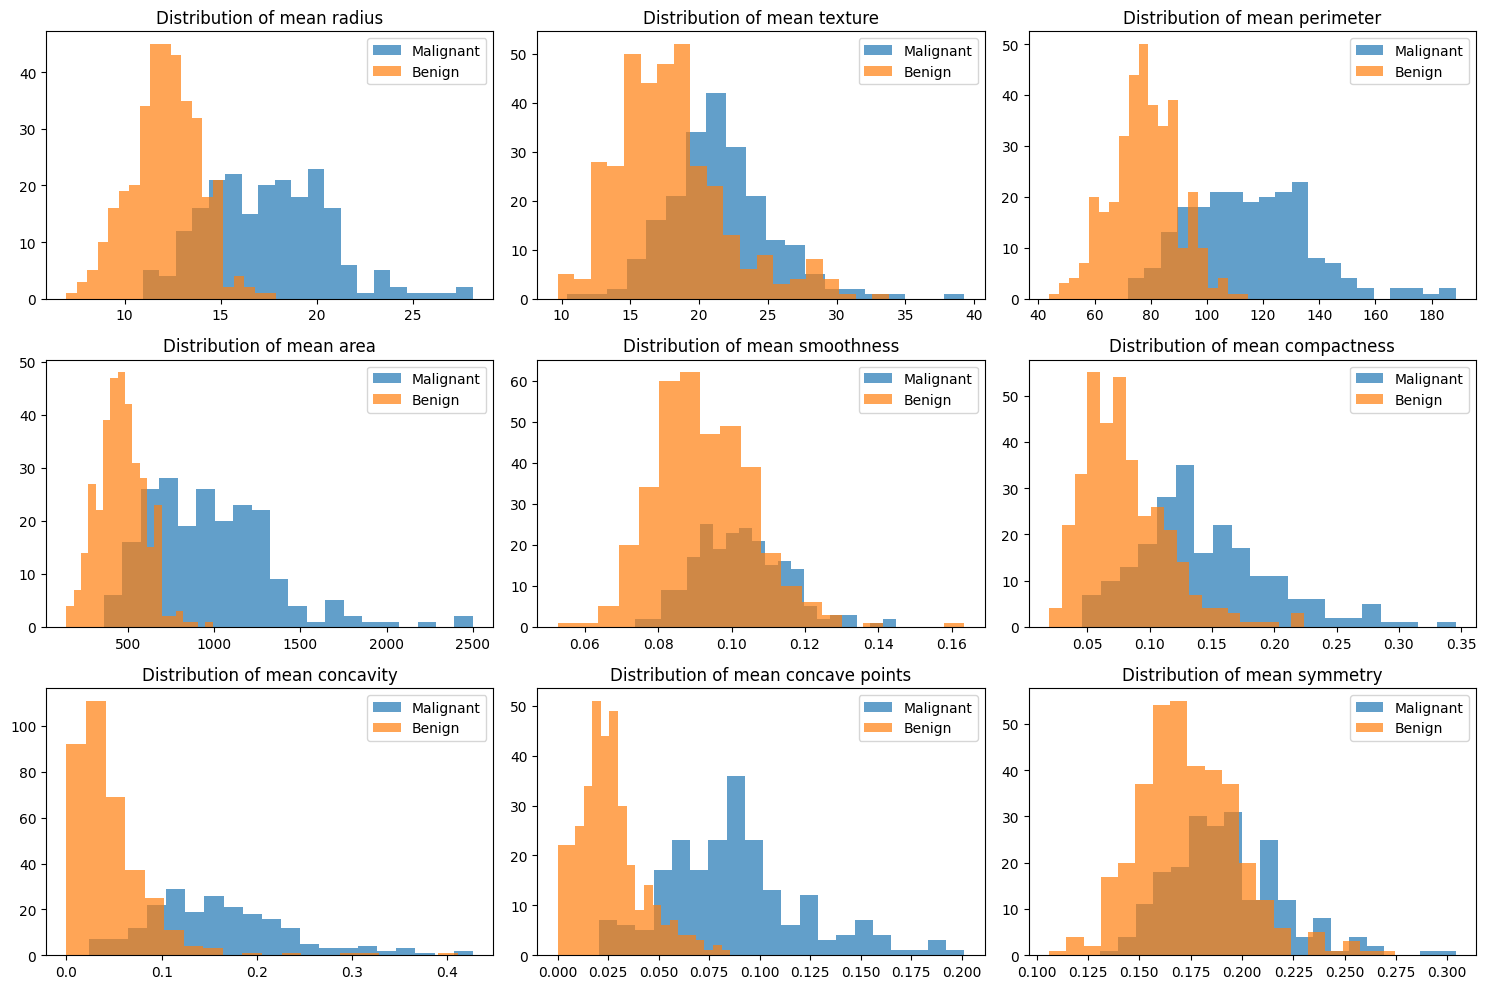

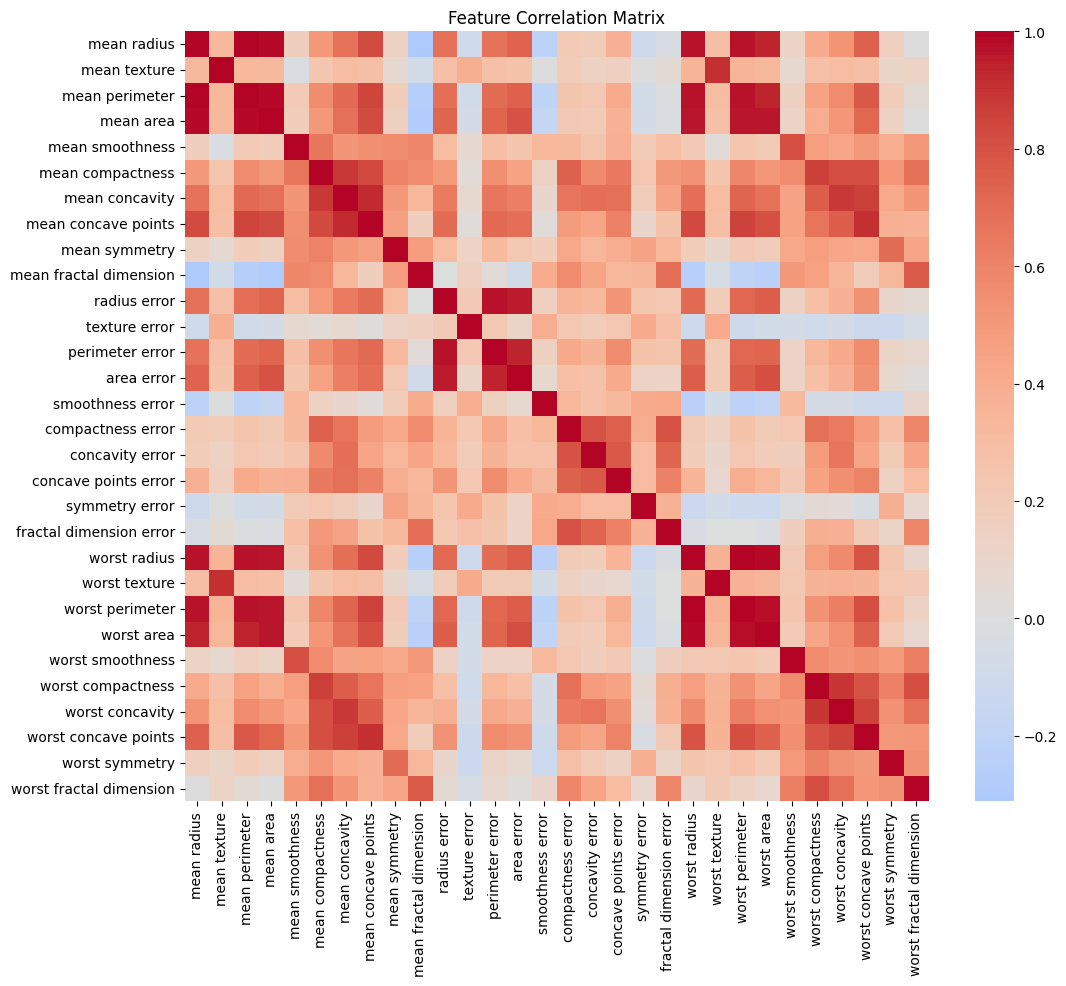

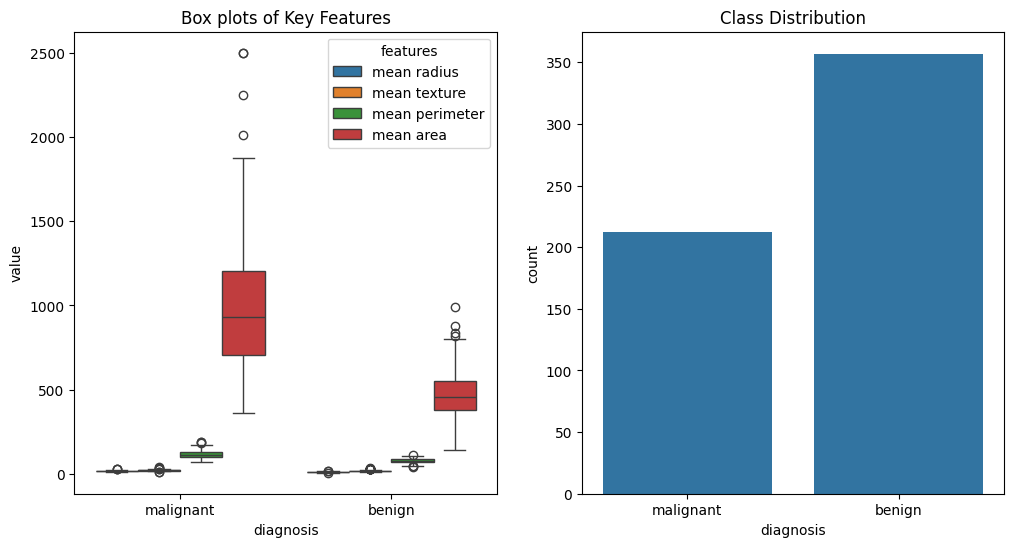


Key observations from EDA:
- Features show clear separation between malignant and benign cases
- Some features are highly correlated (e.g., radius, perimeter, area)
- Dataset is balanced enough for SVM without needing resampling


In [ ]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# 1. Feature distributions
plt.figure(figsize=(15, 10))

# Plot first 9 features distributions by diagnosis
for i in range(9):
    plt.subplot(3, 3, i+1)
    feature = feature_names[i]
    plt.hist(df[df['diagnosis'] == 'malignant'][feature], alpha=0.7, label='Malignant', bins=20)
    plt.hist(df[df['diagnosis'] == 'benign'][feature], alpha=0.7, label='Benign', bins=20)
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(['target', 'diagnosis'], axis=1).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# 3. Box plots for key features
plt.figure(figsize=(12, 6))
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
df_melted = pd.melt(df, id_vars=['diagnosis'], value_vars=selected_features,
                   var_name='features', value_name='value')

plt.subplot(1, 2, 1)
sns.boxplot(x='diagnosis', y='value', hue='features', data=df_melted)
plt.title('Box plots of Key Features')

# 4. Class distribution
plt.subplot(1, 2, 2)
sns.countplot(x='diagnosis', data=df)
plt.title('Class Distribution')
plt.show()

print("\nKey observations from EDA:")
print("- Features show clear separation between malignant and benign cases")
print("- Some features are highly correlated (e.g., radius, perimeter, area)")
print("- Dataset is balanced enough for SVM without needing resampling")

In [ ]:
print("\n=== DATA SPLITTING AND SCALING ===")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

# Scale the features (CRUCIAL for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed using StandardScaler")
print("Mean of scaled training features:", np.mean(X_train_scaled, axis=0)[:5])
print("Std of scaled training features:", np.std(X_train_scaled, axis=0)[:5])


=== DATA SPLITTING AND SCALING ===
Training set size: 455
Test set size: 114
Training set class distribution: [170 285]
Test set class distribution: [42 72]

Feature scaling completed using StandardScaler
Mean of scaled training features: [-4.31742554e-15  2.24606658e-15 -7.38359313e-16  1.71779562e-16
  5.22695440e-15]
Std of scaled training features: [1. 1. 1. 1. 1.]


In [ ]:
print("\n=== BASELINE SVM MODELS WITH DEFAULT PARAMETERS ===")

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
baseline_results = {}

for kernel in kernels:
    print(f"\n--- Training {kernel.upper()} Kernel SVM ---")

    # Create and train SVM
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = svm_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    baseline_results[kernel] = {
        'model': svm_model,
        'accuracy': accuracy,
        'f1_score': f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Support vectors: {svm_model.support_vectors_.shape[0]}")

# Display baseline comparison
print("\n=== BASELINE MODEL COMPARISON ===")
baseline_df = pd.DataFrame(baseline_results).T
print(baseline_df[['accuracy', 'f1_score']].round(4))


=== BASELINE SVM MODELS WITH DEFAULT PARAMETERS ===

--- Training LINEAR Kernel SVM ---
Accuracy: 0.9737
F1-Score: 0.9790
Support vectors: 32

--- Training RBF Kernel SVM ---
Accuracy: 0.9825
F1-Score: 0.9861
Support vectors: 97

--- Training POLY Kernel SVM ---
Accuracy: 0.9123
F1-Score: 0.9351
Support vectors: 145

--- Training SIGMOID Kernel SVM ---
Accuracy: 0.9298
F1-Score: 0.9437
Support vectors: 66

=== BASELINE MODEL COMPARISON ===
         accuracy  f1_score
linear   0.973684  0.979021
rbf      0.982456  0.986111
poly     0.912281  0.935065
sigmoid  0.929825  0.943662


In [ ]:
print("\n=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===")

# Tune RBF Kernel
print("\n1. Tuning RBF Kernel...")
param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
    'kernel': ['rbf']
}

grid_rbf = GridSearchCV(
    SVC(random_state=42),
    param_grid_rbf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_rbf.fit(X_train_scaled, y_train)

print("Best parameters for RBF:", grid_rbf.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_rbf.best_score_))

# Tune Linear Kernel
print("\n2. Tuning Linear Kernel...")
param_grid_linear = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}

grid_linear = GridSearchCV(
    SVC(random_state=42),
    param_grid_linear,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_linear.fit(X_train_scaled, y_train)

print("Best parameters for Linear:", grid_linear.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_linear.best_score_))


=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===

1. Tuning RBF Kernel...
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters for RBF: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.9844

2. Tuning Linear Kernel...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters for Linear: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.9845


In [ ]:
print("\n=== FINAL MODEL EVALUATION ===")

# Get best models
best_rbf = grid_rbf.best_estimator_
best_linear = grid_linear.best_estimator_

# Evaluate on test set
models = {
    'RBF (Tuned)': best_rbf,
    'Linear (Tuned)': best_linear,
    'RBF (Baseline)': SVC(kernel='rbf', random_state=42).fit(X_train_scaled, y_train),
    'Linear (Baseline)': SVC(kernel='linear', random_state=42).fit(X_train_scaled, y_train)
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Parameters': model.get_params()
    })

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Create results comparison
results_df = pd.DataFrame(results)
print("\n=== FINAL COMPARISON ===")
print(results_df[['Model', 'Accuracy', 'F1-Score']].round(4))


=== FINAL MODEL EVALUATION ===

RBF (Tuned):
  Accuracy: 0.9825
  F1-Score: 0.9861

Linear (Tuned):
  Accuracy: 0.9825
  F1-Score: 0.9861

RBF (Baseline):
  Accuracy: 0.9825
  F1-Score: 0.9861

Linear (Baseline):
  Accuracy: 0.9737
  F1-Score: 0.9790

=== FINAL COMPARISON ===
               Model  Accuracy  F1-Score
0        RBF (Tuned)    0.9825    0.9861
1     Linear (Tuned)    0.9825    0.9861
2     RBF (Baseline)    0.9825    0.9861
3  Linear (Baseline)    0.9737    0.9790



=== RESULTS VISUALIZATION ===


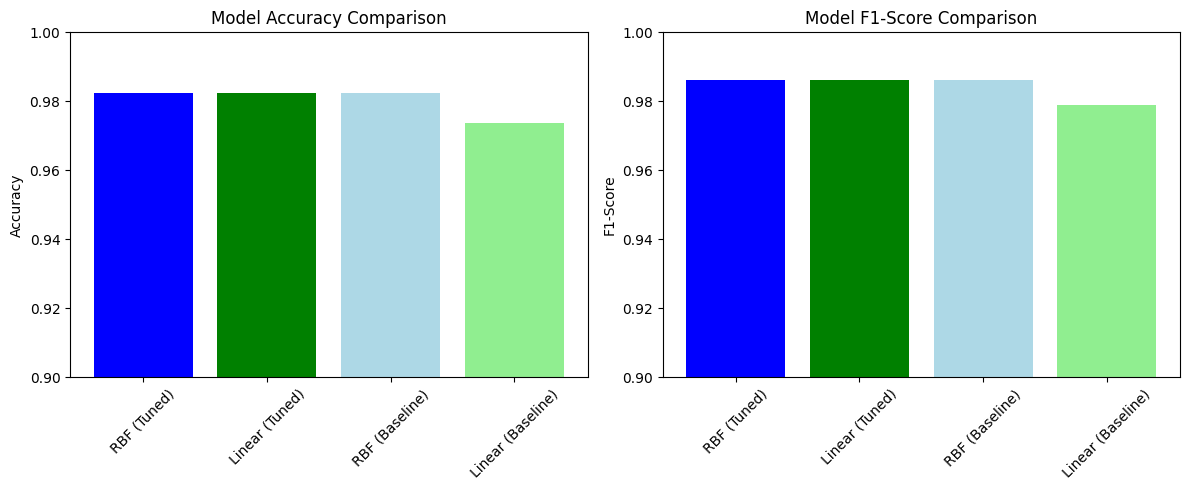

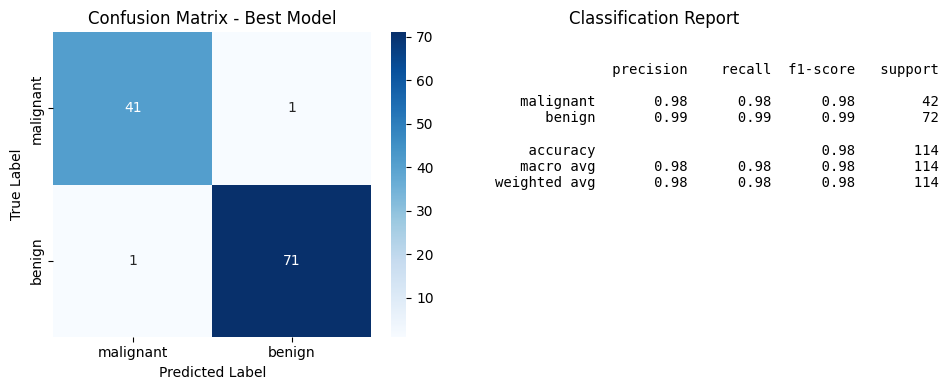

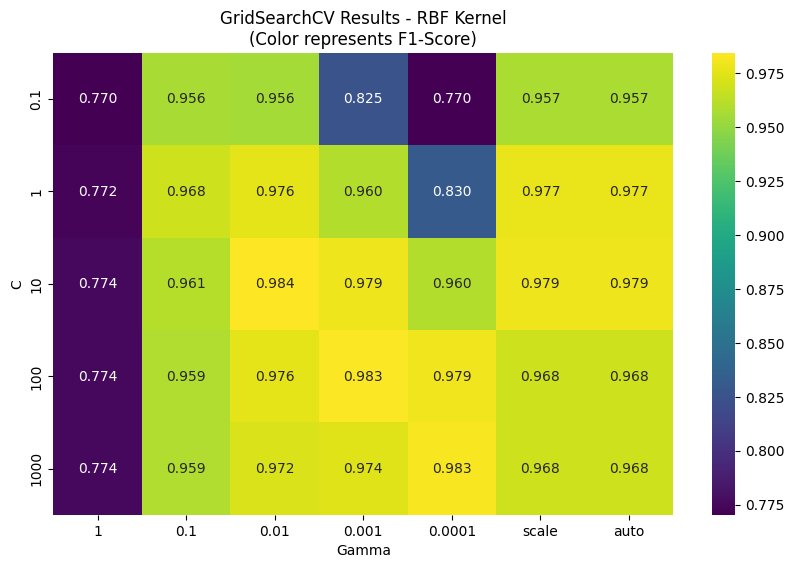

In [ ]:
print("\n=== RESULTS VISUALIZATION ===")

# 1. Performance comparison bar plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models_names = results_df['Model']
accuracy_scores = results_df['Accuracy']
plt.bar(models_names, accuracy_scores, color=['blue', 'green', 'lightblue', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
f1_scores = results_df['F1-Score']
plt.bar(models_names, f1_scores, color=['blue', 'green', 'lightblue', 'lightgreen'])
plt.title('Model F1-Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)
plt.ylabel('F1-Score')

plt.tight_layout()
plt.show()

# 2. Confusion Matrix for best model
best_model = best_rbf  # or choose based on results
y_pred_best = best_model.predict(X_test_scaled)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Best Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. Classification report
plt.subplot(1, 2, 2)
report = classification_report(y_test, y_pred_best, target_names=target_names, output_dict=False)
plt.text(0.1, 0.9, report, fontfamily='monospace', fontsize=10, verticalalignment='top')
plt.axis('off')
plt.title('Classification Report')

plt.tight_layout()
plt.show()

# 4. Hyperparameter heatmap for RBF (if you want to show grid search results)
plt.figure(figsize=(10, 6))
# Extract CV results
cv_results = grid_rbf.cv_results_
scores = cv_results['mean_test_score'].reshape(len(param_grid_rbf['C']), len(param_grid_rbf['gamma']))

sns.heatmap(scores, annot=True, fmt='.3f',
            xticklabels=param_grid_rbf['gamma'],
            yticklabels=param_grid_rbf['C'],
            cmap='viridis')
plt.title('GridSearchCV Results - RBF Kernel\n(Color represents F1-Score)')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()